In [1]:
import numpy as np
import re
import torch
from torch.utils.data import Dataset, DataLoader
from scipy import sparse
from collections import Counter
from tqdm import tqdm
import random
random.seed(12312)
import matplotlib.pyplot as plt
import os    
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

## Part 1: Representing Text Data

### Problem 1

In [4]:
def tokenize(text):
    return text.split(' ')

### Problem 2

In [110]:
def better_tokenize(text):
    text = str(text).lower()                            
    text = re.sub("'", "", text) # get rid of contractions, replace with empty string
    text = re.sub("[^a-z0-9]"," ", text) # get rid of non-alphanumeric characters, replace with spaces
    text = re.sub(r"\b\w{1,3}\b"," ", text)  # get rid of words < 4 letters, replace with spaces
    
    return text.split()        


### Problem 3

In [8]:
def threshold_and_tokenize(doc_list, tokenize_alg, threshold=0):
    all_tokens = []

    tokenized_docs = []
    for doc in tqdm(doc_list, total=len(doc_list), desc="tokenizing each doc"):
        doc = tokenize_alg(doc)
        all_tokens.extend(doc)
        tokenized_docs.append(doc)

    if threshold == 0:
        return tokenized_docs
        
    total_counter = Counter(all_tokens)

    thresholded_words = list(set([word for word in total_counter if total_counter[word] >= threshold]))
    word_col_map = dict()
    for i, word in enumerate(thresholded_words):
        word_col_map[word] = i

    return tokenized_docs, word_col_map, thresholded_words
    
def generate_tdm(tokenized_docs, word_col_map):
    row_ind = []
    col_ind = []
    data = []
    for row, tokenized_doc in tqdm(enumerate(tokenized_docs), total=len(tokenized_docs), desc="building sparse matrix representation"):
        counter = Counter(tokenized_doc)
        for word, count in counter.items():
            if word in word_col_map:
                row_ind.append(row)
                col_ind.append(word_col_map[word])
                data.append(count)
    return sparse.csr_matrix((data, (row_ind, col_ind)))

### read input in and process

In [10]:
import csv

def read_file(filename, full_data=False):
    doc_list = []
    ids = []
    if full_data:
        y = []
        model = []
    with open(filename, 'r', newline='', encoding="utf8") as file:
        csv_reader = csv.reader(file)
        header = next(csv_reader)
        for row in csv_reader:
            ids.append(row[0])
            if full_data:
                doc_list.append(row[2])
                y.append(1 if row[3].lower() == 'true' else 0)
                model.append(row[1].lower())
            else:
                doc_list.append(row[1])
    if full_data:
        y = np.array(y)
        model = np.array(model)
        return doc_list, y, model, ids
    else:
        return doc_list, ids


In [11]:
# read in data
train_doc_list, y_train, model_train, train_ids = read_file('train.csv', True)
dev_doc_list, y_dev, model_dev, dev_ids = read_file('dev.csv', True)
test_doc_list, test_ids = read_file('test.student.csv', False)

tokenize_alg = better_tokenize

train_tokenized_docs, word_col_map, col_word_map = threshold_and_tokenize(train_doc_list, tokenize_alg, 250)
dev_tokenized_docs = threshold_and_tokenize(dev_doc_list, tokenize_alg)
test_tokenized_docs = threshold_and_tokenize(test_doc_list, tokenize_alg)

X_train = generate_tdm(train_tokenized_docs, word_col_map)
X_dev = generate_tdm(dev_tokenized_docs, word_col_map)
X_test = generate_tdm(test_tokenized_docs, word_col_map)

building sparse matrix representation: 100%|██████████████████████████████████| 10000/10000 [00:00<00:00, 49937.72it/s]


## Part 2: Logistic Regression in numpy

### Problem 4

In [14]:
def sigmoid(x):
    return 1/(np.exp(-x) + 1) 

### Problem 5

credit to :https://stackoverflow.com/questions/74836313/numpy-function-adding-the-log-of-the-exponential-python for "logaddexp"

In [16]:
def log_likelihood(X, y, beta):
    predictions = X.dot(beta)
    predictions = np.asarray(predictions).flatten()
    y = np.asarray(y).flatten()
    
    return np.sum(y * predictions - np.logaddexp(0, predictions))

In [17]:
def compute_gradient(beta, xi, yi):   
    pi = sigmoid(xi.dot(beta).item())
    return (pi - yi) * xi.T

### Problem 6

In [19]:
def train_logistic_regression(X, y, learning_rate, num_steps=-1, threshold=-1, likelihood_interval=50):
    X = sparse.hstack([X, np.ones((X.shape[0], 1))]).tocsr()
    beta = np.zeros((X.shape[1], 1))

    likelihoods = []
    count = 0

    if num_steps > 0:
        for i in tqdm(range(num_steps), desc="training logistic regression w/ specified steps"):
            if count%likelihood_interval == 0:
                likelihood = log_likelihood(X, y, beta)
                likelihoods.append(likelihood)
            count += 1

            idx = i % X.shape[0]
            grad_step = learning_rate*compute_gradient(beta, X[idx], y[idx])
            beta -= grad_step
    else:
        old_lhood = 0
        new_lhood = log_likelihood(X, y, beta)
        while abs(old_lhood - new_lhood) >= threshold:
            old_lhood = new_lhood
            if count%likelihood_interval == 0:
                likelihoods.append(new_lhood)
            count += 1

            i = random.randint(0, X.shape[0]-1)
            grad_step = learning_rate*compute_gradient(beta, X[i], y[i])
            beta -= grad_step

            new_lhood = log_likelihood(X, y, beta)
    return beta, likelihoods, count

### Problem 7

In [21]:
def predict(X, beta):
    X = sparse.hstack([X, np.ones((X.shape[0], 1))]).tocsr()
    predictions = []
    for val in sigmoid(X @ beta):
        predictions.append(1 if val >= 0.5 else 0)
    return predictions

### Problem 8: testing model

In [23]:
learning_rate = 5e-5
num_steps = 1000
beta_np_learned, likelihoods, count = train_logistic_regression(X_train, y_train, learning_rate, num_steps=num_steps, likelihood_interval=20)

training logistic regression w/ specified steps: 100%|███████████████████████████| 1000/1000 [00:00<00:00, 3586.23it/s]


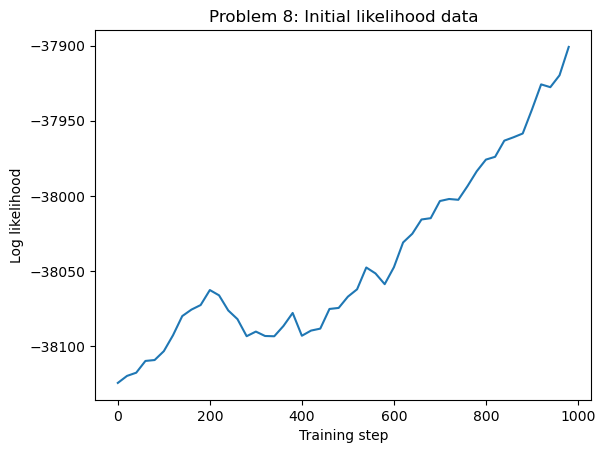

In [24]:
xaxis = [i*20 for i in range(50)]
plt.plot(xaxis, likelihoods)
plt.xlabel('Training step')
plt.ylabel('Log likelihood')
plt.title('Problem 8: Initial likelihood data')
plt.show()

### Problem 9: fine-tuning model

In [26]:
learning_rate = 5e-4
threshold = 1e-8
beta_np_learned, likelihoods, count = train_logistic_regression(X_train, y_train, learning_rate,threshold=threshold, likelihood_interval=100)

In [27]:
learning_rate = 5e-4
num_steps = 550002*3
beta_np_learned, likelihoods, count = train_logistic_regression(X_train, y_train, learning_rate, num_steps=num_steps, likelihood_interval=100)

training logistic regression w/ specified steps: 100%|█████████████████████| 1650006/1650006 [04:12<00:00, 6546.06it/s]


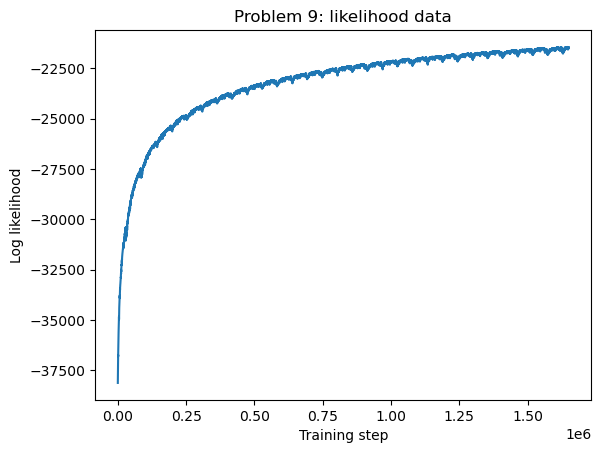

In [28]:
xaxis = [i*100 for i in range(len(likelihoods))]
plt.plot(xaxis, likelihoods)
plt.xlabel('Training step')
plt.ylabel('Log likelihood')
plt.title('Problem 9: likelihood data')
plt.show()

In [29]:
def f1score(predicted, actual):
    tp = 0
    fp = 0
    fn = 0
    for i in range(len(predicted)):
        pred = predicted[i]
        if pred == 1 and actual[i] == 1:
            tp += 1
        elif pred == 1 and actual[i] == 0:
            fp += 1
        elif pred == 0 and actual[i] == 1:
            fn += 1
    return 2*tp/(2*tp + fp + fn)

In [30]:
pred_dev = predict(X_dev, beta_np_learned)
print("f1 score for dev data:")
print(f1score(pred_dev, y_dev))

f1 score for dev data:
0.7739010447466982


### Problem 10

In [32]:
pred_test = predict(X_test, beta_np_learned)
with open('rmsh_np.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['id', 'label'])
    for i in range(len(pred_test)):
        pred = 'True' if pred_test[i] == 1 else 'False'
        writer.writerow([test_ids[i], pred])

## Part 3

### Problem 11

In [35]:
def to_sparse_tensor(arr):
    #arr = arr.tocoo()
    #i = np.vstack((arr.row, arr.col))
    #v = arr.data
    #return torch.sparse_csr_tensor(i, v, arr.shape)
    return torch.sparse_csr_tensor(crow_indices=arr.indptr, col_indices=arr.indices, values=arr.data, size=arr.shape, dtype=torch.float32)

In [36]:
X_train_tensor = to_sparse_tensor(X_train)
y_train_tensor = torch.from_numpy(y_train).to(dtype=torch.float32)

X_dev_tensor = to_sparse_tensor(X_dev)
y_dev_tensor = torch.from_numpy(y_dev).to(dtype=torch.float32)

X_test_tensor = to_sparse_tensor(X_test)

C:\Users\User\AppData\Local\Temp\ipykernel_2516\1416984357.py:6: UserWarning: Sparse CSR tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\SparseCsrTensorImpl.cpp:55.)
  return torch.sparse_csr_tensor(crow_indices=arr.indptr, col_indices=arr.indices, values=arr.data, size=arr.shape, dtype=torch.float32)


### Problem 12

In [38]:
class LogisticRegression(torch.nn.Module):

    def __init__(self, num_features):
        super().__init__()
        self.logistic_layer = torch.nn.Linear(num_features, 1)
    
    def forward(self, inputs):
        return torch.sigmoid(self.logistic_layer(inputs))

In [39]:
def get_prediction_pytorch(model, X):
    predictions = []
    predicted_labels = []
    with torch.no_grad():
        for i in range(len(X)):
            pi = model(X[i])
            predictions.append(pi)
            predicted_labels.append(1 if pi.item() >= 0.5 else 0)
    return torch.cat(predictions, dim=0), predicted_labels

In [40]:
def get_loss_and_f1_score(model, X, y, lossobj):
    predictions, pred_labels = get_prediction_pytorch(model, X)
    loss = lossobj(predictions, y).item()
    score = f1score(pred_labels, y.numpy())
    return loss, score

In [41]:
def train_pytorch_logreg(X, y, model, lossobj, optimizer, X_dev_tensor, y_dev_tensor, num_epochs, dev_eval_interval=20, num_steps=100000):
    num_rows = X.shape[0]
    model.train()
    
    count = 0
    
    dev_losses = []
    dev_f1scores = []
    
    for _ in range(num_epochs):
        indices = list(range(num_rows))
        random.shuffle(indices)
        # for each epoch, go to either num_steps or the whole range
        for i in tqdm(range(min(num_rows, num_steps)), desc="iterating through samples"):
            idx = indices[i]
            
            if count % dev_eval_interval == 0:
                model.eval()
    
                devloss, devf1score = get_loss_and_f1_score(model, X_dev_tensor, y_dev_tensor, lossobj)
                dev_losses.append(devloss)
                dev_f1scores.append(devf1score)
                
                model.train()
            count += 1
            optimizer.zero_grad()
            data = X[idx]
            label = y[idx].float().unsqueeze(0)
            output = model(data)
            loss = lossobj(output, label)
            loss.backward()
            optimizer.step()

    return dev_losses, dev_f1scores


### Problem 13

In [43]:
model_13a = LogisticRegression(len(word_col_map)) # number of features
lossobj_13a = torch.nn.BCELoss()
optimizer_13a = torch.optim.SGD(model_13a.parameters())

dev_losses_13a, dev_f1scores_13a = train_pytorch_logreg(X_train_tensor, y_train_tensor,
                                                model_13a, lossobj_13a, optimizer_13a,
                                                X_dev_tensor, y_dev_tensor,
                                                num_epochs=1,
                                                dev_eval_interval=20,
                                                num_steps=1000)

iterating through samples: 100%|██████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.61it/s]


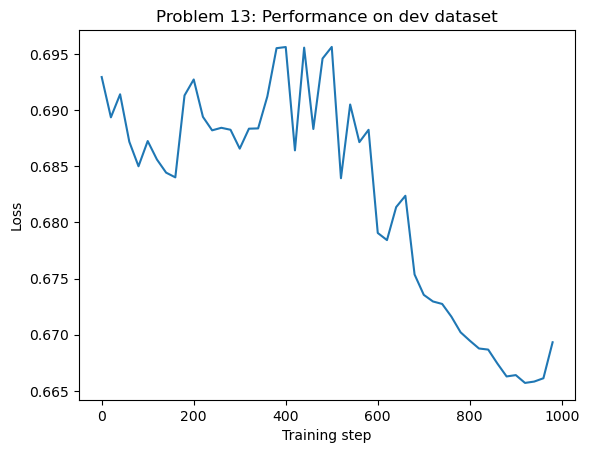

In [44]:
xaxis = [i*20 for i in range(len(dev_losses_13a))]
plt.plot(xaxis, dev_losses_13a)
plt.xlabel('Training step')
plt.ylabel('Loss')
plt.title('Problem 13: Performance on dev dataset')
plt.show()

In [45]:
#Training for real 

model_baseline = LogisticRegression(len(word_col_map)) # number of features
lossobj_baseline = torch.nn.BCELoss()
optimizer_baseline = torch.optim.SGD(model_baseline.parameters())

dev_losses_baseline, dev_f1scores_baseline = train_pytorch_logreg(X_train_tensor, y_train_tensor,
                                                model_baseline, lossobj_baseline, optimizer_baseline,
                                                X_dev_tensor, y_dev_tensor,
                                                num_epochs=1,
                                                dev_eval_interval=50)

iterating through samples: 100%|████████████████████████████████████████████████| 55002/55002 [02:41<00:00, 341.62it/s]


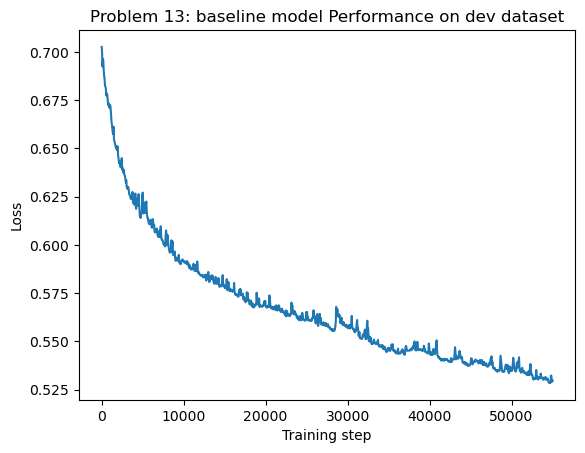

In [46]:
xaxis = [i*50 for i in range(len(dev_losses_baseline))]
plt.plot(xaxis, dev_losses_baseline)
plt.xlabel('Training step')
plt.ylabel('Loss')
plt.title('Problem 13: baseline model Performance on dev dataset')
plt.show()

### Problem 14

In [48]:
#Training for real 

#14a is L2 0.001 penalty
model_14a = LogisticRegression(len(word_col_map)) # number of features
lossobj_14a = torch.nn.BCELoss()
optimizer_14a = torch.optim.SGD(model_14a.parameters(), weight_decay=0.001)

dev_losses_14a, dev_f1scores_14a = train_pytorch_logreg(X_train_tensor, y_train_tensor,
                                                model_14a, lossobj_14a, optimizer_14a,
                                                X_dev_tensor, y_dev_tensor,
                                                num_epochs=1,
                                                dev_eval_interval=50)
#14b is L2 0.1 penalty
model_14b = LogisticRegression(len(word_col_map)) # number of features
lossobj_14b = torch.nn.BCELoss()
optimizer_14b = torch.optim.SGD(model_14a.parameters(), weight_decay=0.1)

dev_losses_14b, dev_f1scores_14b = train_pytorch_logreg(X_train_tensor, y_train_tensor,
                                                model_14b, lossobj_14b, optimizer_14b,
                                                X_dev_tensor, y_dev_tensor,
                                                num_epochs=1,
                                                dev_eval_interval=50)

iterating through samples: 100%|████████████████████████████████████████████████| 55002/55002 [02:42<00:00, 339.07it/s]


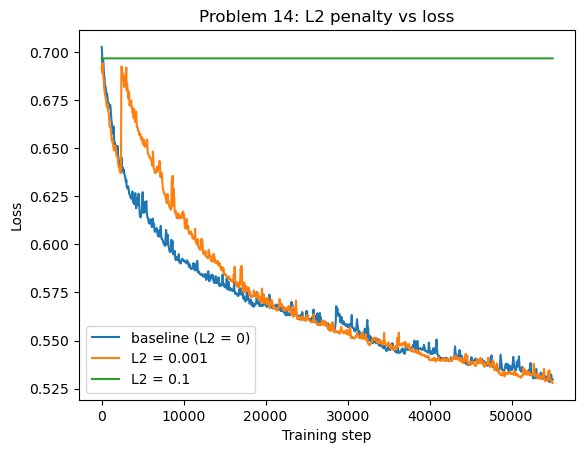

In [49]:
xaxis = [i*50 for i in range(len(dev_losses_baseline))]
plt.plot(xaxis, dev_losses_baseline, label='baseline (L2 = 0)')
plt.plot(xaxis, dev_losses_14a, label='L2 = 0.001')
plt.plot(xaxis, dev_losses_14b, label='L2 = 0.1')
plt.xlabel('Training step')
plt.ylabel('Loss')
plt.title('Problem 14: L2 penalty vs loss')
plt.legend()
plt.show()

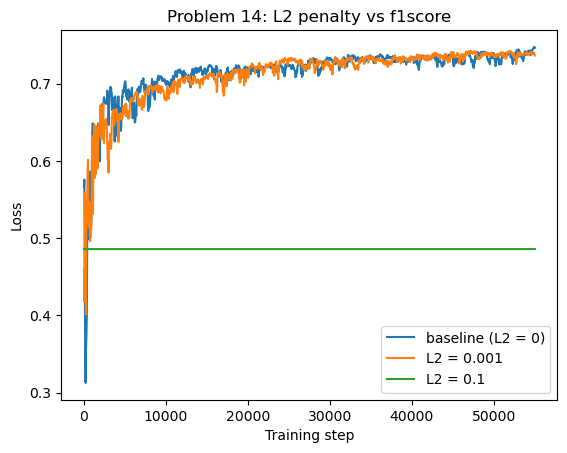

In [50]:
plt.plot(xaxis, dev_f1scores_baseline, label='baseline (L2 = 0)')
plt.plot(xaxis, dev_f1scores_14a, label='L2 = 0.001')
plt.plot(xaxis, dev_f1scores_14b, label='L2 = 0.1')
plt.xlabel('Training step')
plt.ylabel('Loss')
plt.title('Problem 14: L2 penalty vs f1score')
plt.legend()
plt.show()

### Problem 15

In [52]:
#15a is rmsprop
model_15a = LogisticRegression(len(word_col_map)) # number of features
lossobj_15a = torch.nn.BCELoss()
optimizer_15a = torch.optim.RMSprop(model_15a.parameters())

dev_losses_15a, dev_f1scores_15a = train_pytorch_logreg(X_train_tensor, y_train_tensor,
                                                model_15a, lossobj_15a, optimizer_15a,
                                                X_dev_tensor, y_dev_tensor,
                                                num_epochs=1,
                                                dev_eval_interval=50)
#15b is adamw
model_15b = LogisticRegression(len(word_col_map)) # number of features
lossobj_15b = torch.nn.BCELoss()
optimizer_15b = torch.optim.AdamW(model_15b.parameters())

dev_losses_15b, dev_f1scores_15b = train_pytorch_logreg(X_train_tensor, y_train_tensor,
                                                model_15b, lossobj_15b, optimizer_15b,
                                                X_dev_tensor, y_dev_tensor,
                                                num_epochs=1,
                                                dev_eval_interval=50)

iterating through samples: 100%|████████████████████████████████████████████████| 55002/55002 [02:56<00:00, 311.08it/s]


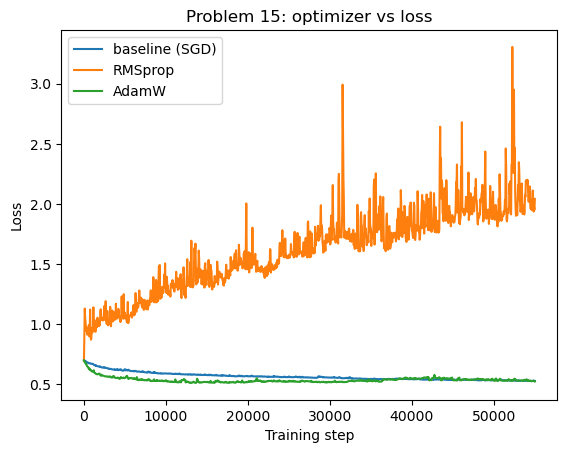

In [53]:
xaxis = [i*50 for i in range(len(dev_losses_baseline))]
plt.plot(xaxis, dev_losses_baseline, label='baseline (SGD)')
plt.plot(xaxis, dev_losses_15a, label='RMSprop')
plt.plot(xaxis, dev_losses_15b, label='AdamW')
plt.xlabel('Training step')
plt.ylabel('Loss')
plt.title('Problem 15: optimizer vs loss')
plt.legend()
plt.show()

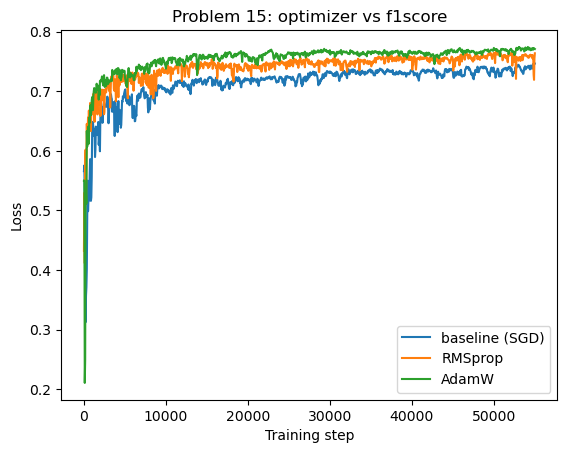

In [54]:
plt.plot(xaxis, dev_f1scores_baseline, label='baseline (SGD)')
plt.plot(xaxis, dev_f1scores_15a, label='RMSprop')
plt.plot(xaxis, dev_f1scores_15b, label='AdamW')
plt.xlabel('Training step')
plt.ylabel('Loss')
plt.title('Problem 15: optimizer vs f1score')
plt.legend()
plt.show()

### Problem 16

In [56]:
#retokenize data using bad tokenize algorithm (instead of better_tokenize)
tokenize_alg = tokenize

train_tokenized_docs_16, word_col_map_16, col_word_map_16 = threshold_and_tokenize(train_doc_list, tokenize_alg, 250)
dev_tokenized_docs_16 = threshold_and_tokenize(dev_doc_list, tokenize_alg)

X_train_16 = generate_tdm(train_tokenized_docs_16, word_col_map_16)
X_dev_16 = generate_tdm(dev_tokenized_docs_16, word_col_map_16)

X_train_tensor_16 = to_sparse_tensor(X_train_16)

X_dev_tensor_16 = to_sparse_tensor(X_dev_16)

building sparse matrix representation: 100%|████████████████████████████████████| 5000/5000 [00:00<00:00, 29781.86it/s]


In [57]:
model_16 = LogisticRegression(len(word_col_map_16)) # number of features
lossobj_16 = torch.nn.BCELoss()
optimizer_16 = torch.optim.SGD(model_16.parameters())

dev_losses_16, dev_f1scores_16 = train_pytorch_logreg(X_train_tensor_16, y_train_tensor,
                                                model_16, lossobj_16, optimizer_16,
                                                X_dev_tensor_16, y_dev_tensor,
                                                num_epochs=1,
                                                dev_eval_interval=50)

iterating through samples: 100%|████████████████████████████████████████████████| 55002/55002 [02:42<00:00, 337.70it/s]


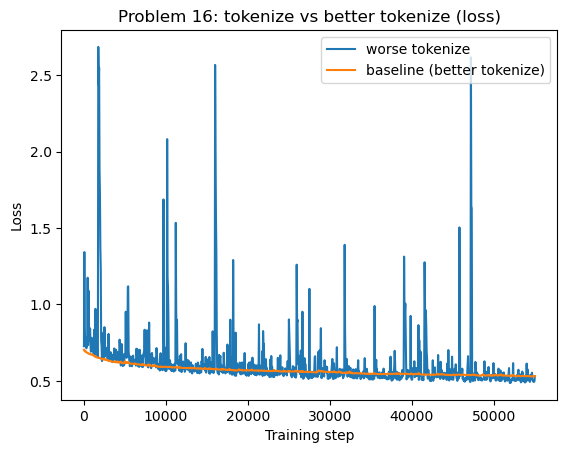

In [58]:
xaxis = [i*50 for i in range(len(dev_losses_baseline))]
plt.plot(xaxis, dev_losses_16, label='worse tokenize')
plt.plot(xaxis, dev_losses_baseline, label='baseline (better tokenize)')
plt.xlabel('Training step')
plt.ylabel('Loss')
plt.title('Problem 16: tokenize vs better tokenize (loss)')
plt.legend()
plt.show()

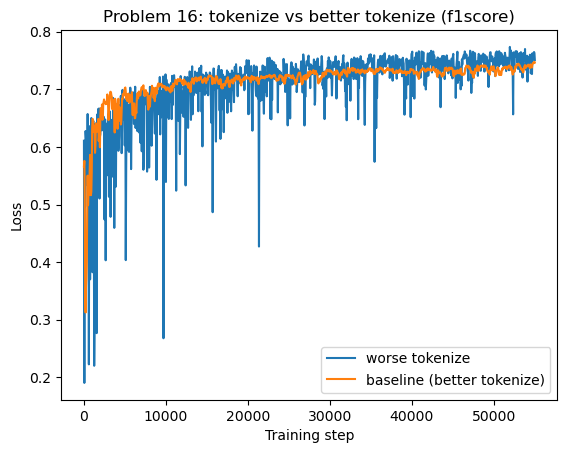

In [59]:
plt.plot(xaxis, dev_f1scores_16, label='worse tokenize')
plt.plot(xaxis, dev_f1scores_baseline, label='baseline (better tokenize)')
plt.xlabel('Training step')
plt.ylabel('Loss')
plt.title('Problem 16: tokenize vs better tokenize (f1score)')
plt.legend()
plt.show()

### Problem 17

In [61]:
#17a is low lr
model_17a = LogisticRegression(len(word_col_map)) # number of features
lossobj_17a = torch.nn.BCELoss()
optimizer_17a = torch.optim.SGD(model_17a.parameters(), lr=0.00001)

dev_losses_17a, dev_f1scores_17a = train_pytorch_logreg(X_train_tensor, y_train_tensor,
                                                model_17a, lossobj_17a, optimizer_17a,
                                                X_dev_tensor, y_dev_tensor,
                                                num_epochs=1,
                                                dev_eval_interval=50)
#17b is high lr
model_17b = LogisticRegression(len(word_col_map)) # number of features
lossobj_17b = torch.nn.BCELoss()
optimizer_17b = torch.optim.SGD(model_17b.parameters(), lr=0.01)

dev_losses_17b, dev_f1scores_17b = train_pytorch_logreg(X_train_tensor, y_train_tensor,
                                                model_17b, lossobj_17b, optimizer_17b,
                                                X_dev_tensor, y_dev_tensor,
                                                num_epochs=1,
                                                dev_eval_interval=50)

iterating through samples: 100%|████████████████████████████████████████████████| 55002/55002 [02:37<00:00, 350.10it/s]


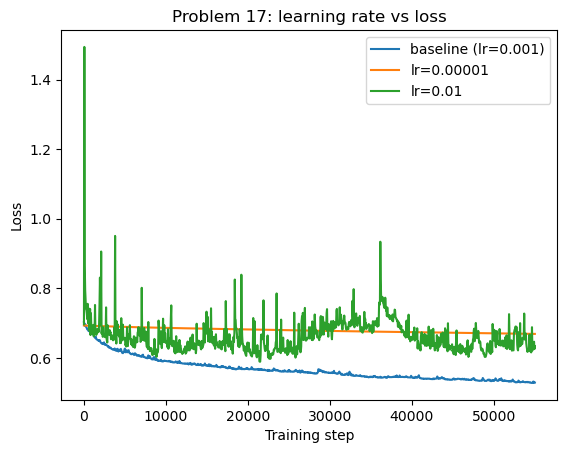

In [62]:
xaxis = [i*50 for i in range(len(dev_losses_baseline))]
plt.plot(xaxis, dev_losses_baseline, label='baseline (lr=0.001)')
plt.plot(xaxis, dev_losses_17a, label='lr=0.00001')
plt.plot(xaxis, dev_losses_17b, label='lr=0.01')
plt.xlabel('Training step')
plt.ylabel('Loss')
plt.title('Problem 17: learning rate vs loss')
plt.legend()
plt.show()

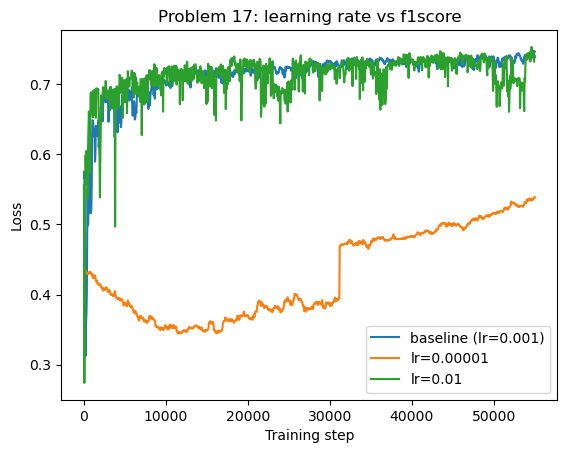

In [63]:
plt.plot(xaxis, dev_f1scores_baseline, label='baseline (lr=0.001)')
plt.plot(xaxis, dev_f1scores_17a, label='lr=0.00001')
plt.plot(xaxis, dev_f1scores_17b, label='lr=0.01')
plt.xlabel('Training step')
plt.ylabel('Loss')
plt.title('Problem 17: learning rate vs f1score')
plt.legend()
plt.show()

### Problem 18 (kaggle submission)

In [65]:
# best model is adamw (model_15b)

predictions, pred_labels = get_prediction_pytorch(model_15b, X_test_tensor)
with open('rmsh_pytorch.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['id', 'label'])
    for i in range(len(pred_test)):
        pred = 'True' if pred_labels[i] == 1 else 'False'
        writer.writerow([test_ids[i], pred])


### Problem 19

In [67]:
def get_highest_beta(model, k, col_word_map):
    coefficients = model.logistic_layer.weight.data
    top_values, top_indices = torch.topk(coefficients, k)
    top_indices = top_indices.flatten()
    return [col_word_map[i] for i in top_indices]

In [84]:
print("L2=0.001")
print(get_highest_beta(model_14a, 30, col_word_map))
print("L2=0.1")
print(get_highest_beta(model_14b, 30, col_word_map))
print("L2=0.0")
print(get_highest_beta(model_baseline, 30, col_word_map))

L2=0.001
['ingredients', 'instructions', 'including', 'sure', 'overall', 'recipe', 'novel', 'enjoy', 'significant', 'else', 'member', 'despite', 'been', 'approach', 'journey', 'named', 'abstract', 'also', 'paper', 'within', 'potential', 'youre', 'extract', 'hearts', 'forever', 'heres', 'article', 'several', 'unique', 'challenges']
L2=0.1
['ended', 'reflects', 'easy', 'stiff', 'essence', 'selected', 'given', 'named', 'glory', 'reliable', 'theories', 'constraints', 'pork', 'items', 'copies', 'managed', 'amazing', '1998', 'room', 'documents', 'method', 'womens', 'entirely', 'pasta', 'pain', 'artistic', 'dialogue', 'noise', 'jump', 'many']
L2=0.0
['ingredients', 'instructions', 'including', 'overall', 'sure', 'recipe', 'enjoy', 'else', 'significant', 'novel', 'been', 'member', 'great', 'named', 'despite', 'approach', 'journey', 'together', 'abstract', 'within', 'method', 'paper', 'article', 'extract', 'youre', 'also', 'text', 'titled', 'potential', 'here']
